In [26]:
import pandas as pd

In [27]:
# Handige Jupyter magic
%config IPCompleter.greedy = True
%matplotlib inline

vektis = pd.read_csv('./vektis/vektis_2020.csv', sep=';', dtype={'geslacht': str, 'leeftijdsklasse': str, 'postcode_3': float}, low_memory=False)
vektis.columns = vektis.columns.str.lower()
vektis = vektis[vektis['leeftijdsklasse'] != '90+']
vektis['leeftijdsklasse'] = vektis['leeftijdsklasse'].astype(float)
vektis = vektis.dropna()
vektis['kosten_farmacien_per_bsn'] = vektis['kosten_farmacie'] / vektis['aantal_bsn']

In [28]:
vektisSexDymmy = pd.get_dummies(vektis, columns=['geslacht'], drop_first=True)
vektisSexDymmy

,leeftijdsklasse,postcode_3,aantal_bsn,aantal_verzekerdejaren,kosten_medisch_specialistische_zorg,kosten_farmacie,kosten_specialistische_ggz,kosten_huisarts_inschrijftarief,kosten_huisarts_consult,kosten_huisarts_mdz,...,kosten_langdurige_ggz,kosten_grensoverschrijdende_zorg,kosten_eerstelijns_ondersteuning,kosten_geriatrische_revalidatiezorg,kosten_eerstelijnsverblijf,kosten_verpleging_en_verzorging,kosten_gzsp,kosten_overig,kosten_farmacien_per_bsn,geslacht_V
0,36.0,753.0,208,206.07,57235.06,12422.63,27442.25,12942.27,5057.54,4223.58,...,0.00,589.91,0,0.00,0.00,0.00,0.00,0.00,59.724183,0
1,35.0,290.0,386,382.27,127924.67,38068.70,110943.17,26591.05,9303.68,3083.85,...,57983.66,69.24,0,6227.55,4056.00,895.98,0.00,17.59,98.623575,0
2,33.0,683.0,208,202.46,100130.83,26515.55,140462.90,14241.00,6955.29,3602.64,...,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,127.478606,0
3,58.0,692.0,208,207.75,491693.09,61234.29,25501.81,14189.33,6965.44,13098.92,...,0.00,0.00,0,0.00,0.00,39688.04,0.00,108.98,294.395625,0
4,51.0,762.0,208,207.07,155556.22,36695.79,0.00,13821.79,5915.35,9144.77,...,0.00,273.56,0,0.00,0.00,1495.92,0.00,16.76,176.422067,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137256,84.0,565.0,64,62.00,266374.32,51880.34,0.00,7745.47,6396.99,16226.57,...,0.00,1900.15,0,0.00,7059.63,89588.27,320.23,884.48,810.630312,0
137257,84.0,529.0,23,20.77,26507.81,23549.43,0.00,2243.99,2548.24,1896.78,...,0.00,0.00,0,0.00,7605.00,9248.79,0.00,0.00,1023.888261,0
137258,84.0,516.0,23,21.56,101959.78,28821.47,0.00,2695.18,4993.82,3034.86,...,0.00,0.00,0,17927.47,2129.58,14530.01,0.00,1270.64,1253.107391,0
137259,84.0,509.0,23,21.16,69928.04,13669.08,0.00,2626.04,1891.16,2322.70,...,0.00,0.00,0,0.00,0.00,24949.37,0.00,642.31,594.307826,0


In [29]:
# get median of kosten_farmacien_per_bsn
median = vektisSexDymmy['kosten_farmacien_per_bsn'].median()

# categorize kosten_farmacien_per_bsn into 2 categories (above and below median)
vektisSexDymmy['kosten_farmacien_per_bsn'] = vektisSexDymmy['kosten_farmacien_per_bsn'].apply(lambda x: 1 if x >= median else 0)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import tree

def fit_decision_tree(y):
    
    X_train, X_test, y_train, y_test = train_test_split(y, vektisSexDymmy[['kosten_farmacien_per_bsn']], test_size=0.2, random_state=42)

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))

    return [f1, (cm.transpose() / cm.sum(axis=1)).transpose(), clf]

geslacht_f1, geslacht_cm, geslacht_model = fit_decision_tree(vektisSexDymmy[['geslacht_V']])
leeftijd_f1, leeftijd_cm, leeftijd_model = fit_decision_tree(vektisSexDymmy[['leeftijdsklasse']])
postcode_f1, postcode_cm, postcode_model = fit_decision_tree(vektisSexDymmy[['postcode_3']])
geslacht_leeftijd_f1, geslacht_leeftijd_cm, geslacht_leeftijd_model = fit_decision_tree(vektisSexDymmy[['geslacht_V', 'leeftijdsklasse']])
geslacht_postcode_f1, geslacht_postcode_cm, geslacht_postcode_model = fit_decision_tree(vektisSexDymmy[['geslacht_V', 'postcode_3']])
leeftijd_postcode_f1, leeftijd_postcode_cm, leeftijd_postcode_model = fit_decision_tree(vektisSexDymmy[['leeftijdsklasse', 'postcode_3']])
geslacht_leeftijd_postcode_f1, geslacht_leeftijd_postcode_cm, geslacht_leeftijd_postcode_model = fit_decision_tree(vektisSexDymmy[['geslacht_V', 'leeftijdsklasse', 'postcode_3']])

pd.Series([geslacht_f1, leeftijd_f1, postcode_f1, geslacht_leeftijd_f1, geslacht_postcode_f1, leeftijd_postcode_f1, geslacht_leeftijd_postcode_f1], index=['geslacht', 'leeftijd', 'postcode', 'geslacht + leeftijd', 'geslacht + postcode', 'leeftijd + postcode', 'geslacht + leeftijd + postcode'])




geslacht                          0.521314
leeftijd                          0.876480
postcode                          0.529106
geslacht + leeftijd               0.879649
geslacht + postcode               0.523799
leeftijd + postcode               0.838046
geslacht + leeftijd + postcode    0.831275
dtype: float64

In [31]:
# Cm van alles
geslacht_leeftijd_postcode_cm

,0,1
0,0.824114,0.175886
1,0.161551,0.838449


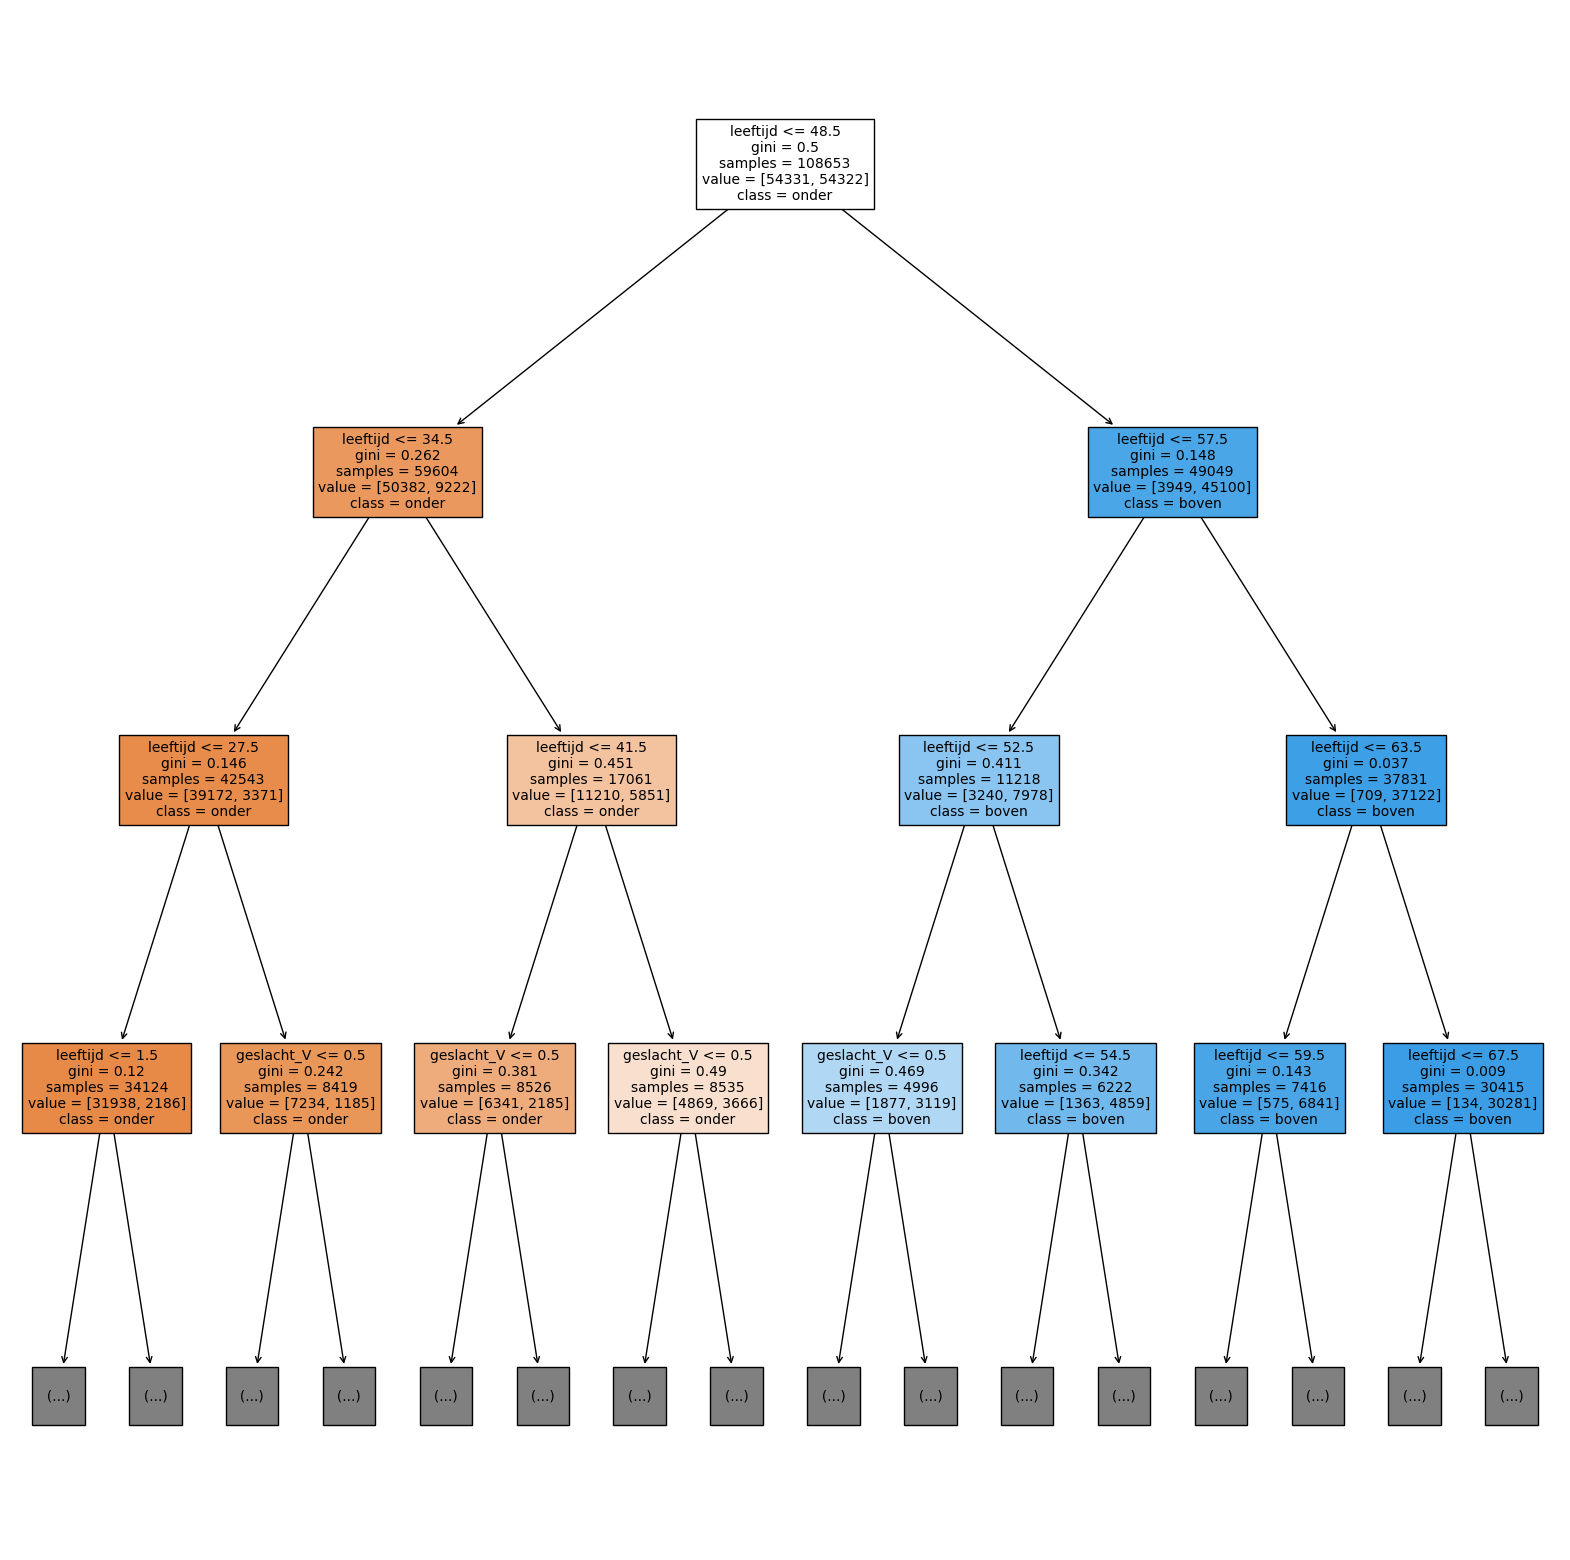

In [33]:
# Plot van alles
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
tree.plot_tree(geslacht_leeftijd_model, feature_names=['geslacht_V', 'leeftijd'], max_depth = 3, fontsize=10, class_names=['onder', 'boven'], filled=True)
plt.show()